# Timeseries with recurrent neural networks

In [14]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Lambda, GRU, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.keras import Model
#from utils import *
tf.keras.backend.set_floatx('float64')
%load_ext tensorboard

2.4.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=8a833f66dd02499ff5abe8eb55900b2c83d37ec95acd7ff857fc45eaa014d6ae
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=354fb13708bb47ffac5caaac6b67456f20137ca26656e78363321f28e062fe23
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
import kerastuner as kt

# Loading data, transforming with a windowed dataset generator
## the windowed datagenerator

Just like we have seen with the images, it is usefull to have a generator.
Our generator will do a few things:
- it helps with managing memory
- we can squeeze more juice out of our data
- we control data manipulation at a seperate place. This means we can leave the data itself intact, and manipulate it in a controlled way just before feeding it to the model, without messing with the data on disk.

Because we will multiply the amount of data we have by manipulating it, it is much more memory efficient to do the manipulation just in time, as opposed to doing all the manipulations, and keeping that in memory.

I will first show you the complete generator, and then walk through every line, explaining what it does.

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, horizon=1):
    ds = tf.data.Dataset.from_tensor_slices(series) 
    ds = ds.window(window_size + horizon, shift=1, drop_remainder=True) # shifted windows. +1 for target value
    ds = ds.flat_map(lambda w: w.batch(window_size + horizon)) # map into lists of size batch+target
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-horizon], w[-horizon:])) # split into data and target, x and y
    return ds.batch(batch_size).prefetch(1)

To show how this works, let's start with a dummy dataset. We will take just the numbers ranging for 0 to 9.

In [5]:
test = [*range(10)]
testserie = tf.data.Dataset.from_tensor_slices(test)

for x in testserie:
    print(x)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


With `data.Dataset.from_tensor_slice` we create a `TensorSliceDataset`.
If we iterate through it, we can see that we have 10 `Tensor`s, each containing of just a single `int32` digit.

For a timeseries, we can create a windowed dataset from a series. This means we slide a window over the data, never leaking data from the future into the past.

In [6]:
window_size = 5
horizon = 1
testserie = testserie.window(window_size + horizon, shift=1, drop_remainder=True) 

for window in testserie:
  print(list(window.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[2, 3, 4, 5, 6, 7]
[3, 4, 5, 6, 7, 8]
[4, 5, 6, 7, 8, 9]


The window-size is the "window" we "slide" over the timeseries. It will be the small chunck of data we will feed into the model to predict the future. 

By setting `window_size` to 5, we will feed the model 5 time steps from the past (our `X`). Because we will also need a certain amount of timesteps into the future to predict, we will add `+1` to our `window_size`. Later on, we will split this off to create a `y`.

With `shift=1`, we let the timeseries skip one step into the future every time.
As you can see, we end up with five timeseries that we can feed into our model!

The `.window` function makes the shape of our data nested. To fix that, we usually use a `flat_map` to flatten the data again. By batching the data in exactly the size of our window (which was `window_size+1`), we will get a flat version of the windowed timeseries

In [7]:
testserie = testserie.flat_map(lambda w: w.batch(window_size + horizon))
for window in testserie:
  print(window)

tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([1 2 3 4 5 6], shape=(6,), dtype=int32)
tf.Tensor([2 3 4 5 6 7], shape=(6,), dtype=int32)
tf.Tensor([3 4 5 6 7 8], shape=(6,), dtype=int32)
tf.Tensor([4 5 6 7 8 9], shape=(6,), dtype=int32)


This is the same like before (we have 5 timeseries), it's just in a shape we can access easier.

Now, let's shuffle them in batches of 2. This means we take a batch of two timeseries, shuffle them, and take the next batch, shuffle them, etc. 

In [8]:
shuffle_buffer = 2
testserie = testserie.shuffle(shuffle_buffer)
for window in testserie:
  print(window)

tf.Tensor([1 2 3 4 5 6], shape=(6,), dtype=int32)
tf.Tensor([2 3 4 5 6 7], shape=(6,), dtype=int32)
tf.Tensor([0 1 2 3 4 5], shape=(6,), dtype=int32)
tf.Tensor([3 4 5 6 7 8], shape=(6,), dtype=int32)
tf.Tensor([4 5 6 7 8 9], shape=(6,), dtype=int32)


But, untill now, we had a window of length `window+1`, being our `X` and `y` together. 

We need to split them into a past that is the `X` data, and a horizon `y` into the future that should be predicted, based on the past.

In [9]:
testserie = testserie.map(lambda w: (w[:-horizon], w[-horizon:]))

for x,y in testserie:
  print('x: ', x)
  print('y: ', y)

x:  tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
y:  tf.Tensor([5], shape=(1,), dtype=int32)
x:  tf.Tensor([2 3 4 5 6], shape=(5,), dtype=int32)
y:  tf.Tensor([7], shape=(1,), dtype=int32)
x:  tf.Tensor([1 2 3 4 5], shape=(5,), dtype=int32)
y:  tf.Tensor([6], shape=(1,), dtype=int32)
x:  tf.Tensor([3 4 5 6 7], shape=(5,), dtype=int32)
y:  tf.Tensor([8], shape=(1,), dtype=int32)
x:  tf.Tensor([4 5 6 7 8], shape=(5,), dtype=int32)
y:  tf.Tensor([9], shape=(1,), dtype=int32)


This is our final data! We have a past, `X`, and a future, `y`.

And finally, we put this into batches. Every time the generator is asked for a new set of data, it will spit out an (x,y) tuple of batch_size. We also use prefetch: this parallelizes the loading of a new batch to speed up things.

In [10]:
batch_size = 2
testserie = testserie.batch(batch_size).prefetch(1)

In [11]:
for x, y in testserie:
    print(x)
    print(y)
    break

tf.Tensor(
[[1 2 3 4 5]
 [0 1 2 3 4]], shape=(2, 5), dtype=int32)
tf.Tensor(
[[6]
 [5]], shape=(2, 1), dtype=int32)


# Conv1D layer

In the lesson about the images, we have already encountered the idea of convolutions: a way the let the model generate features, all by itself. We did this by sliding a 'filter' over the 2D data structure, summarizing what the filter could see.

We can apply exactly the same mechanism, but this time on 1D data.
To see how the Conv1D layer works, let's have a look at a timeserie and apply different filters and kernels.

First, a note on the dimensionality. We have encountered different layers, each requiring a different dimensionality. Uptill now, we have seen as main computational layers:
- `Dense` : expecting `(batch x features)`
- `Conv2D` : expecting `(batch x width x height x channels)`

To that, we will add a `Conv1D` layer. Because we don't have `width x height` in a 1D case, we will shrink those two dimensions into 1D. In the case of timeseries, this dimension will be the amount of timesteps we make. That gives us:
- `Conv1D` : expecting `(batch x timesteps x channels)`

In this case, channels don't mean colors (like in the RGB images) but the will be features of the timeseries.

Let's say we want to predict the weather. We take the past 10 days (so, `window=10`). And we want to predict 1 day into the future (so, `horizon=1`). But how many features do we use? Let's say we use `temperature`, `mm rain` and `hours of sunshine`. That would give us 3 channels. So, with a batch size of 32, we will get a data shape: `(32, 10, 3)`.

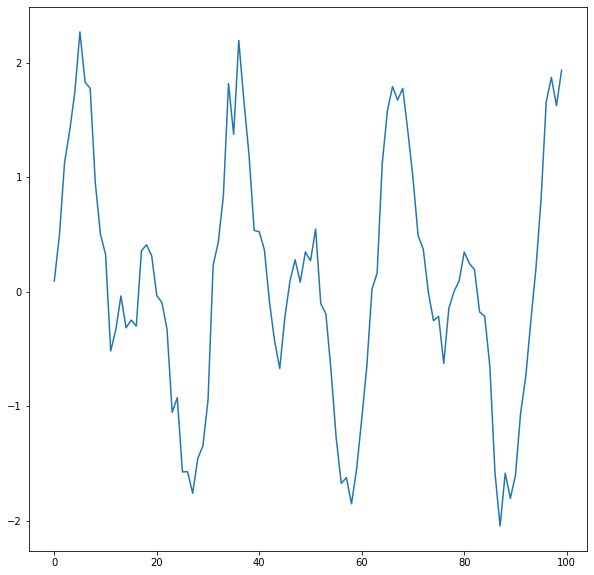

In [12]:
# first, generate a 100 timesteps
t = np.linspace(0, 20, 100)

# we generate a signal, and add some noise
y = np.sin(t) + np.sin(2*t) + np.random.normal(scale=0.2, size=100)

# we get the data in the shape for timeseries: (batch x timesteps x channels)
# in this case, we have just one batch and one channel
y = y[np.newaxis, :, np.newaxis]
plt.figure(figsize=(10,10))
plt.plot(y[0])

In [13]:
y.shape

(1, 100, 1)

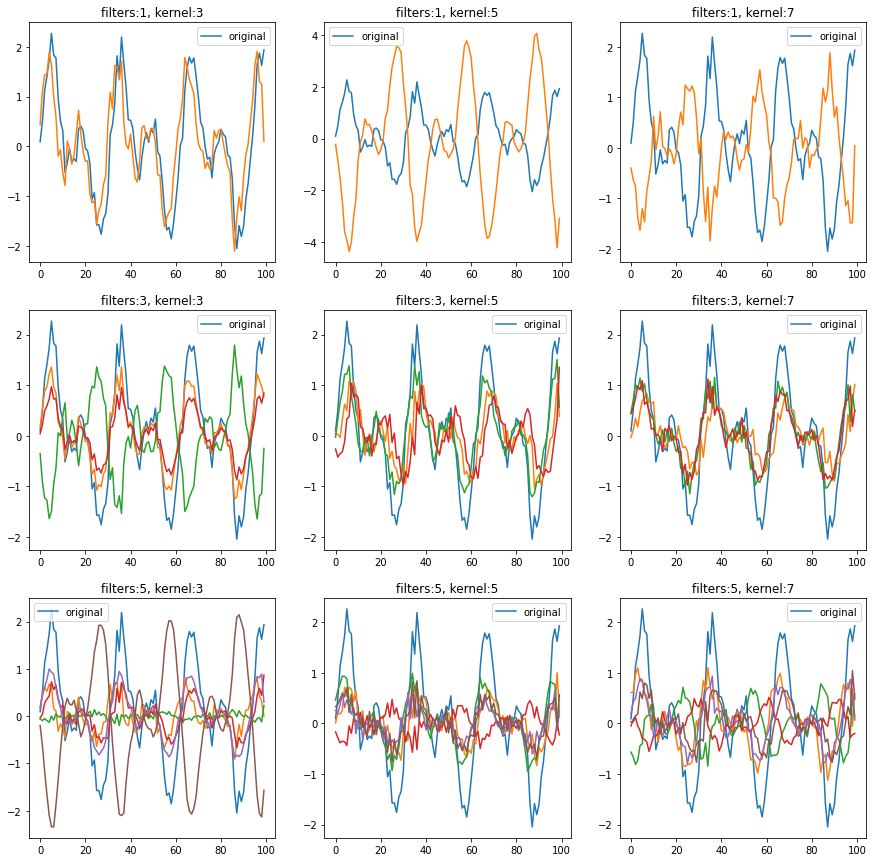

In [14]:
tf.random.set_seed(2)
plt.figure(figsize=(15,15))

for i in range(3):
    # we will test different amounts of filters
    filters = i*2+1
    for j in range(3):
        # prepare the place in the subplot
        place = (i*3)+(j+1)
        ax = plt.subplot(3, 3, place)
        
        # test different sizes of kernels
        kernels = j*2+3
        
        # now, apply the 1D Convolution
        convs = tf.keras.layers.Conv1D(filters, kernels, padding = 'same')(y)
        
        # and plot it.
        plt.plot(y[0], label = 'original')
        plt.title('filters:{0}, kernel:{1}'.format(filters, kernels))
        plt.plot(convs[0]);
        plt.legend()

So, what are features in this case? Some filters might specialize in removing noise (smoothing the signal, eg filter1/kernel5/orange or filter5/kernel3/brown). Others might specialize in increasing the peaks, while flattening out the low intensity signals. Other filters might invert the signal (eg filters3/kernel3/green) etc. etc.

By increasing the amount of filters, we will get more features. 
By increasing the kernelsize, we will get a larger chunck of data that is taken into account to generate a feature.

# Loading actual data

In [4]:
import requests
spots = requests.get('http://www.sidc.be/silso/INFO/snmtotcsv.php', stream=True)
spots = np.genfromtxt(spots.raw, delimiter=';')
data= pd.DataFrame(spots[:, 2:4], columns=['year', 'MonthlyMean'])

This is data on sunspots, since 1749.

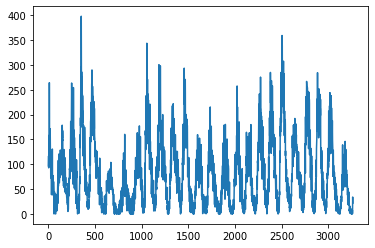

In [5]:
series = data['MonthlyMean']
plt.plot(series)

So let's make a train-test split. Note that we split on past-future.

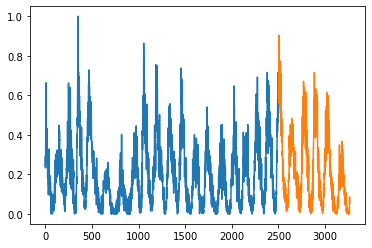

In [6]:
# Train test split
split = 2500
train = series[:split]

norm = max(train)
test = series[split:]


train = train / norm
test = test/ norm
plt.plot(train)
plt.plot(test)

In [7]:
# we need the shape to be: (timesteps x features)
# we have just one feature, so (timesteps x 1)
train = np.array(train)[:, np.newaxis]
test = np.array(test)[:, np.newaxis]
train.shape

(2500, 1)

Now, let's use our windowed datagenerator.

Regarding the windowsize, we will have to ask ourselves: what is a reasonable time, we will need to look into the past to be able to predict the future? If we make it too long, we will get irrelevant data (eg, does the amount of sunspots a hundred years still impact significantly the sunspots in 2020? If you think so, you should increase your window by a lot!)

In [19]:
window_size = 32 
batch_size = 32
shuffle_buffer = 16
horizon = 1
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = windowed_dataset(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [20]:
for x, y in train_set:
    print(x.shape)
    print(y.shape)
    seq_size = x.shape[1]
    break

(32, 32, 1)
(32, 1, 1)


Checking the shape, we see that it is correct:
For the `X`, we have a batch size of 32, and 32 timesteps in the past, with one channel.
For the `y`, we also have a32 batch size, but just 1 timestep for 1 channel.

# Exploring baseline models

In [8]:
def generate_prediction(model, series, window, horizon, figsize=(10,10)):
    ''' After a model is trained, we can check the predictions.
    This function generates predictions, given a model and a timeseries, for a given window in the past
    and a horizon in the future. 
    It returns both the prediction and a plot.'''

    # make sure we have an np.array
    series = np.array(series)
    # calculate the amount of horizons we can predict in a given series
    batches = int(np.floor(len(series) / horizon))
    
    # we migth end up with some rest, where we don't have enough data for the
    # last prediction, so we stop just before that
    end = batches * horizon - window
    yhat = []
    
    # for every batch
    for i in range(batches):
        # skip the horizons we already predicted
        shift = i * horizon
        
        # take the window from the past we need for predicting, skipping what we already predicted
        X = series[0+shift:window+shift]
        
        # add a dimension, needed for the timeseries
        X = X[np.newaxis, :]
        
        # predict the future horizon, given the past window
        y = model.predict(X).flatten()[:horizon]
        # collect as a list of predictions
        yhat.append(y)
    
    # transform the appended results into a single numpy array
    yhat = np.concatenate(yhat, axis=None)[:end]

    plt.figure(figsize=figsize)
    plt.plot(yhat, label = 'prediction')
    plt.plot(series[window:], label = 'actual')
    plt.legend()
    
    return yhat

In [22]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

## Linear model
We start with a linear baselinemodel, of just a single `Dense` layer with one unit. This is equal to a linear model.

In [23]:
%%time
result = {}
from tensorflow.keras.layers import Flatten
model = Sequential([
    Flatten(input_shape = [32,1]),
    Dense(horizon)
])
model.compile(loss="mse", optimizer=Adam())
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
CPU times: user 44.7 ms, sys: 0 ns, total: 44.7 ms
Wall time: 47.2 ms


In [24]:
# to clean up previous logs
!rm -rf logs

In [25]:
%%time
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import os
logdir = os.path.join("logs", "base")
tb = TensorBoard(logdir, histogram_freq=1)
result['base'] = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)

CPU times: user 1min 21s, sys: 14.4 s, total: 1min 35s
Wall time: 1min 4s


# Simple RNN, 1 unit
And a simpleRNN. As `input_shape`, we leave out the batch_size as we always do. So we need to specify `(timesteps x channels)`. In this case, we can choose not to specify the length of the timesteps by setting it to `None`. The model will pick that up by itself. We will set the channels to one.

In [26]:
%%time
model = Sequential([
    SimpleRNN(1, input_shape=[None, 1])
])

logdir = os.path.join("logs", "simpleRNN")
tb = TensorBoard(logdir, histogram_freq=1)

model.compile(loss="mse", optimizer=Adam())
result['simpleRNN'] = model.fit(train_set,epochs=100, callbacks=[tb], validation_data=valid_set, verbose=0)

CPU times: user 1min 42s, sys: 13.2 s, total: 1min 56s
Wall time: 1min 12s


In [ ]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


Ok, so far, the RNN isn't really impressive. With just one unit, it is outperformed by the Dense layer with one unit, which is essentially a simple linear model! Let's see the actual prediction of the RNN.

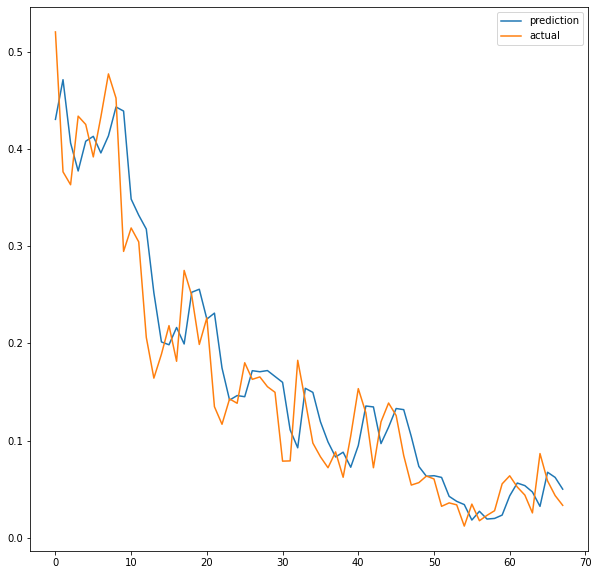

In [27]:
pred = generate_prediction(model, test[:100], window = 32, horizon = horizon)

It seems like it is making a naive prediction (just taking the past as a prediction. If it rained yesterday, my prediction is that it will rain tomorrow).

In addition to that, it is a slow learner. Let's combine the two layers.

In [28]:
%%time
model = Sequential([
    SimpleRNN(1, input_shape=[None, 1]),
    Dense(horizon)
])
logdir = os.path.join("logs", "Linear_RNN")
tb = TensorBoard(logdir, histogram_freq=1)
model.compile(loss="mse", optimizer=Adam(lr=1e-3))
model.fit(train_set,epochs=100,callbacks=[tb], validation_data=valid_set, verbose=0)

CPU times: user 1min 47s, sys: 13.9 s, total: 2min
Wall time: 1min 15s


In [ ]:
%tensorboard --logdir logs

We still have a very basic model, with just one RNN and one Deep layer with a single unit. But the synergy between the two is obvious; combined, they are better. Let's increase the units of the RNN a bit.

In [29]:
%%time
model = Sequential([
    SimpleRNN(16, input_shape=[None, 1]),
    Dense(horizon)
])
logdir = os.path.join("logs", "Linear_RNN16")
tb = TensorBoard(logdir, histogram_freq=1)
model.compile(loss="mse", optimizer=Adam(lr=1e-3))
model.fit(train_set,epochs=100,callbacks=[tb], validation_data=valid_set, verbose=0)

And let's add another layer.

In [30]:
%%time
model = Sequential([
    SimpleRNN(16, input_shape=[None, 1], return_sequences=True),
    SimpleRNN(16),
    Dense(horizon)
])
logdir = os.path.join("logs", "Linear_DeepRNN16")
tb = TensorBoard(logdir, histogram_freq=1)
model.compile(loss="mse", optimizer=Adam(lr=1e-3))
model.fit(train_set,epochs=100,callbacks=[tb], validation_data=valid_set, verbose=0)

So, the deep RNN has the best performance so far, at least, at the start. But it seems to hit some kind of plateau.

And, based on just this, we can see how difficult it is to improve upon the baseline model... While the models train faster, the improvement on the loss is not really impressive.

## Deep RNN, learning rate schedule
If you see a learning rate flatten out like that, you might want to consider dropping the learning rate after some initial epochs. Initially, it drops very steep. That is good. But then, it really flattens out, meaning it just stopped learning. That could mean two things:

- the signal is just noisy, and there is no pattern left to discover. We can't learn noise, so we can't improve above a certain threshold.
- While the high learning rate helps to drop fast, it is to high to finetune the model. It keeps 'overshooting' the sweet spot.

This first problem can only by solved by adding new features, or other tricks to reduce noise. The last problem could be solved by a learning rate scheduler. If you want to refresh that, read page 359 and 360 from the book.

In this case, probably the second problem is at hand; you can deduce that from the pattern the last 50 epochs of the validation se.

In addition to that, we will also increase the amount of units.

In [32]:
%%time
def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 5 # the model seems to start hit a plateau around 5, so let's slowly start to decrease
    # then it drops exponentially untill
    droptill = 100
    
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

logdir = os.path.join("logs", "Linear_DeepRNN16_lrs")
tb = TensorBoard(logdir, histogram_freq=1)
lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

model = Sequential([
    SimpleRNN(16, input_shape=[None, 1], return_sequences=True),
    SimpleRNN(16),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(lr=1e-3))
history = model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[lrs, tb], verbose=0)

CPU times: user 3min 5s, sys: 14.3 s, total: 3min 19s
Wall time: 1min 59s


In [ ]:
#!rm -rf $logdir

First, let's check our result. Use as a regex `Deep|base` to compare the two deep models, one with lrs, one without, and the baseline.

In [ ]:
%tensorboard --logdir logs

So, we have two models. Both are a two-layer-deep RNN with 16 units, and a single Linear model as the last layer. The only difference is the learning rate schedule. It really has a lot of impact! The learning becomes much smoother, less bumpy. The performance is also better then the baseline, and it trains much fast.

You could experiment with when the schedule stops to decay the lr (I myself experimented with stopping the decay at epoch 30, based on the new plateau) but that actually decreased performance.

Schedules are also a bit trail and error, but the main intuition is this:

* In the beginning, you start with a higher learing rate, because you had random weights and need to learn a lot.
* After some learning took place, you should start finetuning instead of learning new things. Making the learningrate much smaller does exactly that.

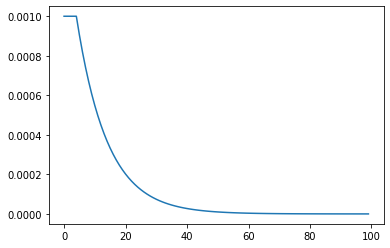

In [34]:
# we can check the learningrate drop by hand
plt.plot(history.history['lr'])

In [35]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, None, 16)          288       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


Note the shapes. The first layer outputs a 3D-shape with `(batch, timesteps, channels)`. That is usefull, because we can feed that into a next `RNN` layer that requires 3D data!

We obtained this by added `return_sequences=True`.

For the second RNN layer, we dropped that argument, and the ouput is flattened into `(batch, channels)`, which is what we need for our Dense layer. Another option would be to use a GlobalAveragPooling layer. Let's have a look at the actual prediction:

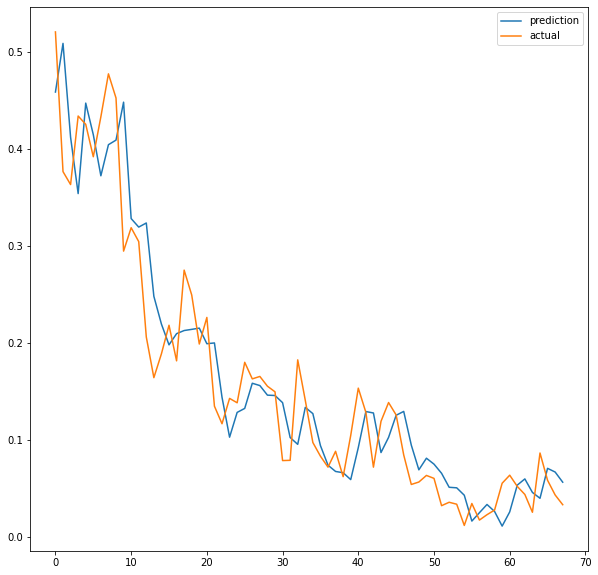

In [36]:
pred = generate_prediction(model, test[:100], window = 32, horizon = horizon)

We no longer have a naive prediction. Ideally you want to see the line stay in the middle (so it does not has a bias to either direction).

Let's see if we can improve by adding convolutions.

In [37]:
%%time

logdir = os.path.join("logs", "Linear_DeepRNN16_lrs_conv")
tb = TensorBoard(logdir, histogram_freq=1)

model = Sequential([
    Conv1D(filters=16, kernel_size=3, strides=1, padding="valid",
                        input_shape=[None, 1]),
    SimpleRNN(16, return_sequences=True),
    SimpleRNN(16),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(lr=1e-3))
model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[lrs, tb], verbose=0)

CPU times: user 3min 22s, sys: 12 s, total: 3min 34s
Wall time: 2min 1s


In [ ]:
%tensorboard --logdir logs

Well, look at that. The improvement is small, but still, we improved the model. And if you look carefully, the model is still improving, but slow.

What we learn from this:

*   We seem to consistently hit a plateau. It's really hard to get beyond that. This might be due to the noise in the data (after all, there is a lot of noise in this process), but we also might have a model that is too simple.
*   We could also try to tune the decay rate in the scheduler; because the model is still improving at the end. Or, simply try running it for even more epochs (eg, 400) to see what happens.
*   Deeper models works better, for this dataset
*   A learningrate schedule seems to work good, for this dataset.


## LSTM
Now, let's move on to LSTMs and see if that improves the model.

In [ ]:
%%time

logdir = os.path.join("logs", "Linear_DeepLSTM16_lrs_conv")
tb = TensorBoard(logdir, histogram_freq=1)

model = Sequential([
    Conv1D(filters=16, kernel_size=3, strides=1, padding="valid",
                        input_shape=[None, 1]),
    LSTM(16, input_shape=[None, 1], return_sequences=True),
    LSTM(16, input_shape=[None, 1]),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(lr=1e-3))
model.fit(train_set,epochs=100, validation_data=valid_set, callbacks=[lrs, tb], verbose=0)

CPU times: user 6min 15s, sys: 15.3 s, total: 6min 31s
Wall time: 3min 36s


In [ ]:
%tensorboard --logdir logs

This is actually worse as what we had! But this doesnt mean that LSTM's are a bad idea.

We could be locked in a certain direction at this point: we have been working with a windowsize of 32. While that might work great for a RNN, an LSTM or GRU might profit from longer sequences to learn from. Why this is the case, should be obvious from the theory! We didn't introduced memorygates just for fun, remember?

So, a good idea, when moving to a recurrent type with memory, is to tune the window size. 

In [45]:
%%time

for window in range(16, 8*9+1, 8):

    window_size = window
    batch_size = 32
    shuffle_buffer = 25
    horizon = 1
    train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
    valid_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)

    name = "LSTM_windowsize_{0}".format(window_size)
    logdir = os.path.join("windowtuning", name) 
    # let's use another folder name as logs, because we don't want to compare this with our results so far;
    # this is just an experiment on it's own. Using another folder keeps things cleaner.
    tb = TensorBoard(logdir, histogram_freq=1)
    
    model = Sequential([
    LSTM(32, return_sequences=True, input_shape=[None, 1]),
    LSTM(32),
    Dense(horizon)
    ])
    
    
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.001))

    print('starting: ', name)
    result[name] = model.fit(train_set,epochs=20, validation_data=valid_set, callbacks=[lrs, tb], verbose=0)

starting:  LSTM_windowsize_16
starting:  LSTM_windowsize_24
starting:  LSTM_windowsize_32
starting:  LSTM_windowsize_40
starting:  LSTM_windowsize_48
starting:  LSTM_windowsize_56
starting:  LSTM_windowsize_64
starting:  LSTM_windowsize_72
CPU times: user 19min 9s, sys: 33.1 s, total: 19min 42s
Wall time: 10min 49s


In [ ]:
%tensorboard --logdir windowtuning

So, higher windows seem to improve the model! A windowsize of 48 seems to perform the best.



# Hypertuning
By now, we have some intuitions about the models, learning rate, layers etc.

## On the dimensionality of your searchspace
As you might have noticed by now, hypertuning is not a magic potion that works by throwing wide ranges of parameters at it. It is very easy to make your search space much to big to find something usefull!

How to check if your searchspace is to big? A good way to do so, is to calculate the size of what you are searching for. In the model below, we search for:

1. amount of units (10 options) 
2. celltype (2 options)
3. extra layers (4 options)

With this, we can calculate the total size of the search space: that would be 10 * 2 * 4, which equals 80.
If we set the `max_epochs` of the tuner to 5, we will sample 10 combinations. That means we are sampling 10 out of 80 options. While that is just 12.5%, it is enough to get a reasonable result.

Let's say you might still wonder what the best learning rate is, or even the best optimizer.
So, we could add:

4. optimizer (adam, sgd, rmsprop) (3 options)
5. learning rate (1e-2, 1e-3, 1e-4) (3 options)

While this might seems like just a small addition, our search space has suddenly become much bigger! We will now search 10 * 2 * 4 * 3 * 3 = 720 options! Sampling just 10 of them, will give us just 1.4% of the searchspace!

The chance that you will end up with a solution that is even *worse* than what we did by hand, is huge! One way to encounter this would be to increase the amount of models to test. But this would take hours, if we want to get to the same 12.5% coverage. So, to get the best results with hypertuning, keep your searchspace limited (unless you have vast resources to search the space!).

## What do we want to hypertune?

There are more ways to use hypertuning. One approach could be, to try to improve the SimpleRNN model we found so far by hand. We could expect to at least improve the best model we have found so far, maybe slightly.

Another approach with the hypertuner could be, to explore the GRU/LSTM architectures. As long as we keep an eye on the ratio between the dimensionality of the search space and the amount of models we will explore, we can make informed decisions about our strategy.

E.g. : you could still decide to take a lucky swing at it, and try 0.1% of the models. You could be lucky, after all. Sometimes, it gives really good insights about your model, because it could point you in new directions! So, that might be really valuable. But if you do that, it shouldn't suprise you that you might get worse results as what you did by hand.

In [9]:
window_size = 48
batch_size = 32
shuffle_buffer = 25
horizon = 1
train_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [49]:
def build_model(hp):
    input = Input(shape = [None, 1])
    Conv1D(filters=16, kernel_size=3, strides=1, padding="valid",
                        input_shape=[None, 1])(input)

    units = hp.Int('units', 32, 196, 16)
    celltype = hp.Choice('Type', ['LSTM', 'GRU'])

    # first layer
    if celltype == "LSTM":
        x = LSTM(units, return_sequences=True)(input)
    if celltype == "GRU":
        x = GRU(units, return_sequences=True)(input)

    # inner layers, if any
    for i in range(hp.Int('layers', 0, 3)):
        name = 'layer_{0}'.format(i)
        if celltype == "LSTM":
            x = LSTM(units, return_sequences=True)(x)
        if celltype == "GRU":
            x = GRU(units, return_sequences=True)(x)
    
    # last layer
    if celltype == "LSTM":
        x = LSTM(units)(x)
    if celltype == "GRU":
        x = GRU(units)(x)

    output = Dense(horizon)(x)
    
    optimizer = Adam(lr=1e-3)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="mse", optimizer=optimizer)
    return model

What is the dimensionality of our searchspace? Well, let's calculate:
- units (10)
- celltype (2)
- innerlayers (4)

that gives us 10 * 2 * 4 = 80.

If we search 10 models, the chance that we will find the best model is pretty high, or at least, come pretty close to a best model within these settings.

We might not improve the simpleRNN, but we will have explored this new searchspace good enough. After we have run this search, we could consider adding a Conv1D layer, but if you do that, keep in mind what you are doing with the searchspace. Options are:

*   Accept that you are gambling
*   Reduce the searchspace by fixing other values (maybe based on what you have learned from the first hypersearch)
*   Increase the amount of models explored by increasing max_epochs


In [53]:
%%time
# takes about 20 minutes
import kerastuner as kt

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=5,
    factor=3,
    overwrite=True,
    directory='ktuner',
    project_name='ts'
)
tuner.search(train_set, epochs = 5, validation_data = valid_set)

Trial 10 Complete [00h 01m 49s]
val_loss: 0.004924065015638827

Best val_loss So Far: 0.004167144982141198
Total elapsed time: 00h 19m 59s
INFO:tensorflow:Oracle triggered exit
CPU times: user 32min 25s, sys: 2min 44s, total: 35min 9s
Wall time: 19min 59s


In [54]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps.values

{'Type': 'GRU',
 'layers': 1,
 'tuner/bracket': 1,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 2,
 'tuner/round': 1,
 'tuner/trial_id': '003555e35b7b4961aa34c49b0b8cadc3',
 'units': 144}

In [55]:
model = tuner.get_best_models()[0]
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gru (GRU)                    (None, None, 144)         63504     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 144)         125280    
_________________________________________________________________
gru_2 (GRU)                  (None, 144)               125280    
_________________________________________________________________
dense (Dense)                (None, 1)                 145       
Total params: 314,209
Trainable params: 314,209
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time
# running this on CPU takes about 40 sec per epoch.
# GPU reduces that to about 11 seconds.
def scheduler(epoch, lr):
    # first n epochs, the learning rate stays high
    stabletill = 5 # the model seems to start hit a plateau around 5, so let's slowly start to decrease
    # then it drops exponentially untill
    droptill = 100
    
    if epoch < stabletill or epoch >=droptill:
        learning_rate = lr
    
    if epoch >= stabletill and epoch <droptill:
        learning_rate = lr * tf.math.exp(-0.1)
    
    # with this, we can check the lr in the history of the fit (or tensorboard)
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

lrs = tf.keras.callbacks.LearningRateScheduler(scheduler)

logdir = os.path.join("logs", "hyper")
tb = TensorBoard(logdir, histogram_freq=1)

model = Sequential([
    LSTM(144, input_shape=[None, 1], return_sequences=True),
    LSTM(144, return_sequences=True),
    LSTM(144),
    Dense(horizon)
])

model.compile(loss="mse", optimizer=Adam(lr=1e-3))
model.fit(train_set,epochs=50, validation_data=valid_set, callbacks=[lrs, tb], verbose=1)

Epoch 1/50
77/77 [==============================] - 22s 153ms/step - loss: 0.0194 - val_loss: 0.0061
Epoch 2/50
77/77 [==============================] - 11s 137ms/step - loss: 0.0070 - val_loss: 0.0053
Epoch 3/50
77/77 [==============================] - 11s 138ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 4/50
77/77 [==============================] - 11s 139ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 5/50
77/77 [==============================] - 11s 140ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 6/50
77/77 [==============================] - 11s 138ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/50
77/77 [==============================] - 11s 137ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 8/50
77/77 [==============================] - 11s 137ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 9/50
77/77 [==============================] - 11s 137ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 10/50
77/77 [==============================] - 10s 136ms/step - loss: 0.0049 - val_lo

This is actually worse than our RNN. Hypothesis about what is happening:

1.   Our data has so much noise, that we are never able to outperform the 0.00295 val_loss we got manually. A SimpleRNN could just be just complex enough to get the best results at speed. GRU/LSTM might get better over time, but won't improve on our simpleRNN just because of the noise in the data. We will need more features to improve. We might want to consult literature / an expert about predictability of sunspots.
2.   There might be long term dependencies that a LSTM/GRU could learn in addition to our simpleRNN model. We just need to tune the learning rate schedule / convolutional layers / windowsize better, and then we might find something that improves our SimpleRNN.

The problem with hypothesis 2 is that we can never be 100% sure, untill we actually find that better model. In the best case, exploring more will give you a higher confidence about which of the two hypothesis is true.